<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatorial-Optimization/blob/main/01_GNN_vs_SA_for_Max_Cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is where we compare Graph Neural Networks vs Simulated Annealing

https://arxiv.org/abs/2206.13211

In [16]:
!pip install -q git+https://github.com/IvanIsCoding/GNN-for-Combinatorial-Optimization.git

  Preparing metadata (setup.py) ... done


We saw the definition of GNNs on the previous one, time to see what simulated annealing is about

In [17]:
from gnn_for_co.core import create_train_state, train_step, get_classification, create_Q_matrix, create_max_cut_model

import jax
import jax.numpy as jnp
import numpy as np
import networkx as nx
import openjij as oj
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

In [18]:
G = nx.convert_node_labels_to_integers(nx.fast_gnp_random_graph(n = 100, p=0.05, seed=2023))

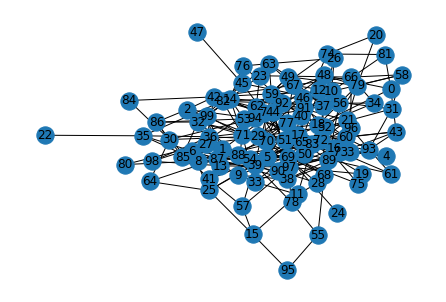

In [19]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), with_labels=True)

In [20]:
sampler = oj.SASampler()

In [21]:
model = create_max_cut_model(G)
qubo_dict, offset = model.to_qubo()

In [22]:
response = sampler.sample_qubo(qubo_dict, num_reads=1000)

In [23]:
response.first.energy

-213.0

In [24]:
node_color = ["lightblue" for i in range(G.number_of_nodes())]
for x, val in response.first.sample.items():
  if val == 1:
    node_color[int(x[2:-1])] = "yellow"

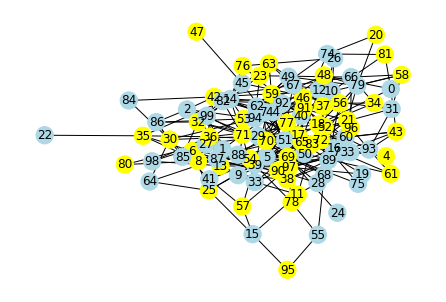

In [25]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), node_color=node_color, with_labels=True)

Notice that simulated annealing found a better solution. Time to 

In [26]:
def inner_solve_with_gnn(G, embedding_size, hidden_size, learning_rate, epochs, dropout_rate, seed=2023, verbose=False):
  A = jnp.array(nx.to_numpy_array(G))
  Q = create_Q_matrix(G)

  rng = jax.random.PRNGKey(seed)
  rng, init_rng = jax.random.split(rng)
  rng, embed_rng = jax.random.split(rng)
  state = create_train_state(G.number_of_nodes(), embedding_size, hidden_size, init_rng, learning_rate, dropout_frac=0.01)
  node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

  for epoch in trange(1, epochs + 1, disable=not verbose):
    rng, dropout_rng = jax.random.split(rng)
    state, metrics = train_step(state=state, node_embeddings=node_embeddings, adj_matrix=A, q_matrix=Q, dropout_rng=dropout_rng)

    if epoch % 25 == 0 and verbose:
      print('train epoch: %d, cost: %.2f' % (epoch, metrics["energy"]))
    
  classification = np.array(get_classification(state.apply_fn, state.params, node_embeddings, A))
  probs = state.apply_fn({"params": state.params}, node_embeddings, A)
  solution = {f"X[{i}]": classification[i] for i in range(G.number_of_nodes())}
  last_energy = metrics["energy"]

  return {
      "classification": classification,
      "probs": probs,
      "energy": last_energy,
      "solution": solution
  }

def solve_with_gnn(G, embedding_size, hidden_size, learning_rate, epochs, dropout_rate, seed=2023, verbose=False, shots=5):
  lower_bound = -G.number_of_nodes()/10.0
  
  for k in range(shots):
    solution = inner_solve_with_gnn(G, embedding_size, hidden_size, learning_rate, epochs, dropout_rate, seed + (k+1)**3, verbose=False)

    if solution["energy"] <= lower_bound:
      break
  
  return solution

In [27]:
def solve_with_annealing(G, num_reads):
  sampler = oj.SASampler()

  model = create_max_cut_model(G)
  qubo_dict, offset = model.to_qubo()

  response = sampler.sample_qubo(qubo_dict, num_reads=num_reads)

  return {
      "sample": response.first.sample,
      "energy": response.first.energy,
      "model": model
  }


Results for d = 3 regular graphs


In [28]:
d3_graphs = {
    i: nx.convert_node_labels_to_integers(nx.random_regular_graph(d=3, n=i, seed=2023)) for i in range(100, 2100, 100)
}

In [29]:
df = pd.DataFrame(columns=['N', 'Max-Cut Size', 'Algorithm'])
gnn_results = []
sa_results = []

In [30]:
for i, G in tqdm(d3_graphs.items()):
  
  annealing_sol = solve_with_annealing(G, num_reads=2000)
  model = annealing_sol["model"]
  sa_results.append(-annealing_sol["energy"])

  print(f"N = {i}, Anneling found {sa_results[-1]}")

  embedding_d0 = int(np.sqrt(i))
  embedding_d1 = embedding_d0//2
  learning_rate = 0.005
  epochs = 10000
  if i < 1400:
    dropout_rate = 0.01
  else:
    dropout_rate = 0.05
  gnn_sol = solve_with_gnn(G, embedding_d0, embedding_d1, learning_rate, epochs, dropout_rate, seed=2023, verbose=False)


  gnn_results.append(
      -model.decode_sample(gnn_sol["solution"], vartype="BINARY").energy
  )
  print(f"N = {i}, Graph Neural Networks found {gnn_results[-1]}")

  0%|          | 0/20 [00:00<?, ?it/s]

N = 100, Anneling found 138.0
N = 100, Graph Neural Networks found 122.0
N = 200, Anneling found 275.0
N = 200, Graph Neural Networks found 241.0
N = 300, Anneling found 413.0
N = 300, Graph Neural Networks found 360.0
N = 400, Anneling found 551.0
N = 400, Graph Neural Networks found 490.0
N = 500, Anneling found 689.0
N = 500, Graph Neural Networks found 602.0
N = 600, Anneling found 828.0
N = 600, Graph Neural Networks found 727.0
N = 700, Anneling found 965.0
N = 700, Graph Neural Networks found 844.0
N = 800, Anneling found 1103.0
N = 800, Graph Neural Networks found 961.0
N = 900, Anneling found 1242.0
N = 900, Graph Neural Networks found 1085.0
N = 1000, Anneling found 1381.0
N = 1000, Graph Neural Networks found 1190.0
N = 1100, Anneling found 1518.0
N = 1100, Graph Neural Networks found 1345.0
N = 1200, Anneling found 1657.0
N = 1200, Graph Neural Networks found 1469.0
N = 1300, Anneling found 1791.0
N = 1300, Graph Neural Networks found 1567.0
N = 1400, Anneling found 1935.0


In [31]:
import seaborn as sns
sns.set_theme()

In [32]:
for n, cut_size in zip(range(100, 2100, 100), gnn_results):
  df.loc[len(df)] = [n, cut_size, "Graph Neural Network"]

In [33]:
for n, cut_size in zip(range(100, 2100, 100), sa_results):
  df.loc[len(df)] = [n, cut_size, "Simulated Annealing"]

[]

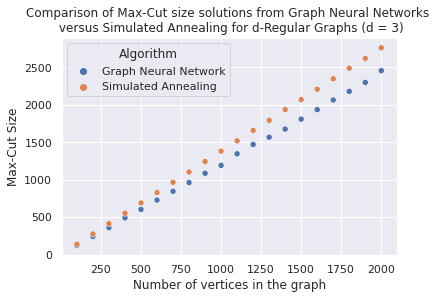

In [34]:
sns.scatterplot(
    data=df, x ="N", y="Max-Cut Size", hue="Algorithm"
).set(
    title="Comparison of Max-Cut size solutions from Graph Neural Networks \n versus Simulated Annealing for d-Regular Graphs (d = 3)",
    ylabel="Max-Cut Size",
    xlabel="Number of vertices in the graph",
)
plt.plot()

Now for d=5

In [35]:
d5_graphs = {
    i: nx.convert_node_labels_to_integers(nx.random_regular_graph(d=5, n=i, seed=2023)) for i in range(100, 2100, 100)
}

In [36]:
df = pd.DataFrame(columns=['N', 'Max-Cut Size', 'Algorithm'])
gnn_results = []
sa_results = []

In [ ]:
for i, G in tqdm(d5_graphs.items()):
  
  annealing_sol = solve_with_annealing(G, num_reads=2000)
  model = annealing_sol["model"]
  sa_results.append(-annealing_sol["energy"])

  print(f"N = {i}, Anneling found {sa_results[-1]}")

  embedding_d0 = int(np.sqrt(i))
  embedding_d1 = embedding_d0//2
  learning_rate = 0.005
  epochs = 10000
  if i < 1400:
    dropout_rate = 0.01
  else:
    dropout_rate = 0.05
  gnn_sol = solve_with_gnn(G, embedding_d0, embedding_d1, learning_rate, epochs, dropout_rate, seed=2023, verbose=False)


  gnn_results.append(
      -model.decode_sample(gnn_sol["solution"], vartype="BINARY").energy
  )
  print(f"N = {i}, Graph Neural Networks found {gnn_results[-1]}")

  0%|          | 0/20 [00:00<?, ?it/s]

N = 100, Anneling found 205.0
N = 100, Graph Neural Networks found 189.0
N = 200, Anneling found 411.0
N = 200, Graph Neural Networks found 371.0
N = 300, Anneling found 623.0
N = 300, Graph Neural Networks found 562.0
N = 400, Anneling found 829.0
N = 400, Graph Neural Networks found 739.0
N = 500, Anneling found 1039.0
N = 500, Graph Neural Networks found 905.0
N = 600, Anneling found 1244.0
N = 600, Graph Neural Networks found 1104.0
N = 700, Anneling found 1455.0
N = 700, Graph Neural Networks found 1269.0
N = 800, Anneling found 1661.0
N = 800, Graph Neural Networks found 1471.0
N = 900, Anneling found 1871.0
N = 900, Graph Neural Networks found 1655.0
N = 1000, Anneling found 2081.0
N = 1000, Graph Neural Networks found 1835.0


In [ ]:
for n, cut_size in zip(range(100, 2100, 100), gnn_results):
  df.loc[len(df)] = [n, cut_size, "Graph Neural Network"]

In [ ]:
for n, cut_size in zip(range(100, 2100, 100), sa_results):
  df.loc[len(df)] = [n, cut_size, "Simulated Annealing"]

In [ ]:
sns.scatterplot(
    data=df, x ="N", y="Max-Cut Size", hue="Algorithm"
).set(
    title="Comparison of Max-Cut size solutions from Graph Neural Networks \n versus Simulated Annealing for d-Regular Graphs (d = 5)",
    ylabel="Max-Cut Size",
    xlabel="Number of vertices in the graph",
)
plt.plot()